In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2025-04-25 22:22:47'

In [2]:
import mysql.connector
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',

    })


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


In [5]:
plt.colormaps['tab20'](1)

(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)

In [6]:
import os

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")



In [7]:
class DbAccessor:
    def __init__(self, db_name, local=False, rlaidb=False, gc=False, gc2=False):
        try:
            if local:
                    self.conn = mysql.connector.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif rlaidb:
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['rlaidbpswd'],
                                            host='198.168.186.104',
                                            database=db_name)

            elif gc:
                self.conn = mysql.connector.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mysql.connector.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3306,
                                            database=db_name)
        except mysql.connector.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def tables(self):
        return pd.read_sql('show tables', self.conn)
    
    def runs(self):
        return pd.read_sql('select * from runs', self.conn)
    
    def q(self, query):
        return pd.read_sql(query, self.conn)

In [8]:
from scipy.ndimage.filters import uniform_filter1d
def moving_avg(x, n):
    return uniform_filter1d(x, size=n)

In [9]:
def conditions_to_str(conditions):
    c_str = ""
    for i, c in enumerate(conditions):
        c_str += str(c[0]) + '=' + str(c[1])
        if i != len(conditions) - 1:
            c_str += " and "
    return c_str

In [10]:
def get_best_hypers(db, swept_parameters, conditions='actor_policy="beta"', ranking_column="rewaurd_auc_50perc", prioritize_finished_seeds=True):
    if prioritize_finished_seeds:
        sweep_results = db.q(f'select {swept_parameters}, avg({ranking_column}), std({ranking_column})/sqrt(count(*)),  count(*) as finished_seeds from summary join runs where summary.run=runs.run and run_status="finished" and {conditions} group by {swept_parameters} order by finished_seeds desc, avg({ranking_column}) desc')
    else:
        sweep_results = db.q(f'select {swept_parameters}, avg({ranking_column}), std({ranking_column})/sqrt(count(*)), count(*) as finished_seeds from summary join runs where summary.run=runs.run and {conditions} group by {swept_parameters} order by avg({ranking_column}) desc')
    best_params = list(zip(swept_parameters.split(','), sweep_results.values[0]))
    completed_runs = db.q(f'select count(*)/1000 as completed_runs from errors join runs where runs.run=errors.run and {conditions_to_str(best_params)} and {conditions}')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(sweep_results), display("best_hypers: "), display(best_params), display(completed_runs)
    return best_params

In [11]:
class DbAccessor:
    def __init__(self, db_name, local=False):
        try:
            if local:
                self.conn = mysql.connector.connect(
                    user="haseebs",
                    unix_socket="/tmp/mysql.sock",  # ← point at your socket
                    database=db_name,
                    # no host/port needed when you specify unix_socket
                )
        except mysql.connector.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)
    def tables(self):
        return pd.read_sql('show tables', self.conn)
    
    def runs(self):
        return pd.read_sql('select * from runs', self.conn)
    
    def q(self, query):
        return pd.read_sql(query, self.conn)


In [12]:
db1 = DbAccessor('baselines_awac_sql_xql_awac', local=True)
db1.runs()

,agent_actor_optimizer_name,agent_actor_optimizer_lr,agent_actor_optimizer_critic_lr_multiplier,agent_actor_optimizer_weight_decay,agent_actor_optimizer_betas,agent_actor_optimizer_eps,agent_actor_policy_policy,agent_actor_policy_mean_init,agent_actor_policy_shape_init,agent_actor_policy_hidden_dim,...,steps,learning_starts,evaluation_steps,evaluation_episodes,n_threads,offline,param_save_steps,timeout,param_stop_steps,device
0,Adam,0.0002,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
1,Adam,0.0002,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
2,Adam,0.0002,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
3,Adam,0.0002,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
4,Adam,0.0002,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
176,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
177,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
178,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu


In [13]:
db2 = DbAccessor('baselines_iql_tawac', local=True)
db2.runs()

,agent_actor_optimizer_name,agent_actor_optimizer_lr,agent_actor_optimizer_critic_lr_multiplier,agent_actor_optimizer_weight_decay,agent_actor_optimizer_betas,agent_actor_optimizer_eps,agent_actor_policy_policy,agent_actor_policy_mean_init,agent_actor_policy_shape_init,agent_actor_policy_hidden_dim,...,steps,learning_starts,evaluation_steps,evaluation_episodes,n_threads,offline,param_save_steps,timeout,param_stop_steps,device
0,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
1,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
2,Adam,0.0003,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
3,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
4,Adam,0.0003,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
116,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
117,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu
118,Adam,0.0010,1.0,0.0,"b'""[0.9, 0.999]""'",1.000000e-08,squashed_gaussian,0.0,1.0,256.0,...,1000000.0,0.0,10000.0,5.0,1.0,True,1000.0,1000.0,250000.0,cpu


In [14]:
dbFH  = DbAccessor('fac_hopper_halfcheetah',        local=True)
dbFW  = DbAccessor('fac_walker2d',                  local=True)


select env_name, env_dataset, seed, agent_fname, agent_num_terms, agent_alpha, agent_critic_optimizer_lr, agent_symmetric_coef, avg(reward), avg(reward_normalized), count(*) as finished_steps from runs join returns where runs.run=returns.run and env_name="walker2d" and env_dataset="medrep" and agent_fname="jensen_shannon" and agent_symmetric_coef=1.0 group by env_name, env_dataset, seed, agent_fname, agent_num_terms, agent_critic_optimizer_lr, agent_alpha, agent_symmetric_coef order by avg(reward_normalized) desc;

agent_fname    | agent_num_terms | agent_symmetric_coef

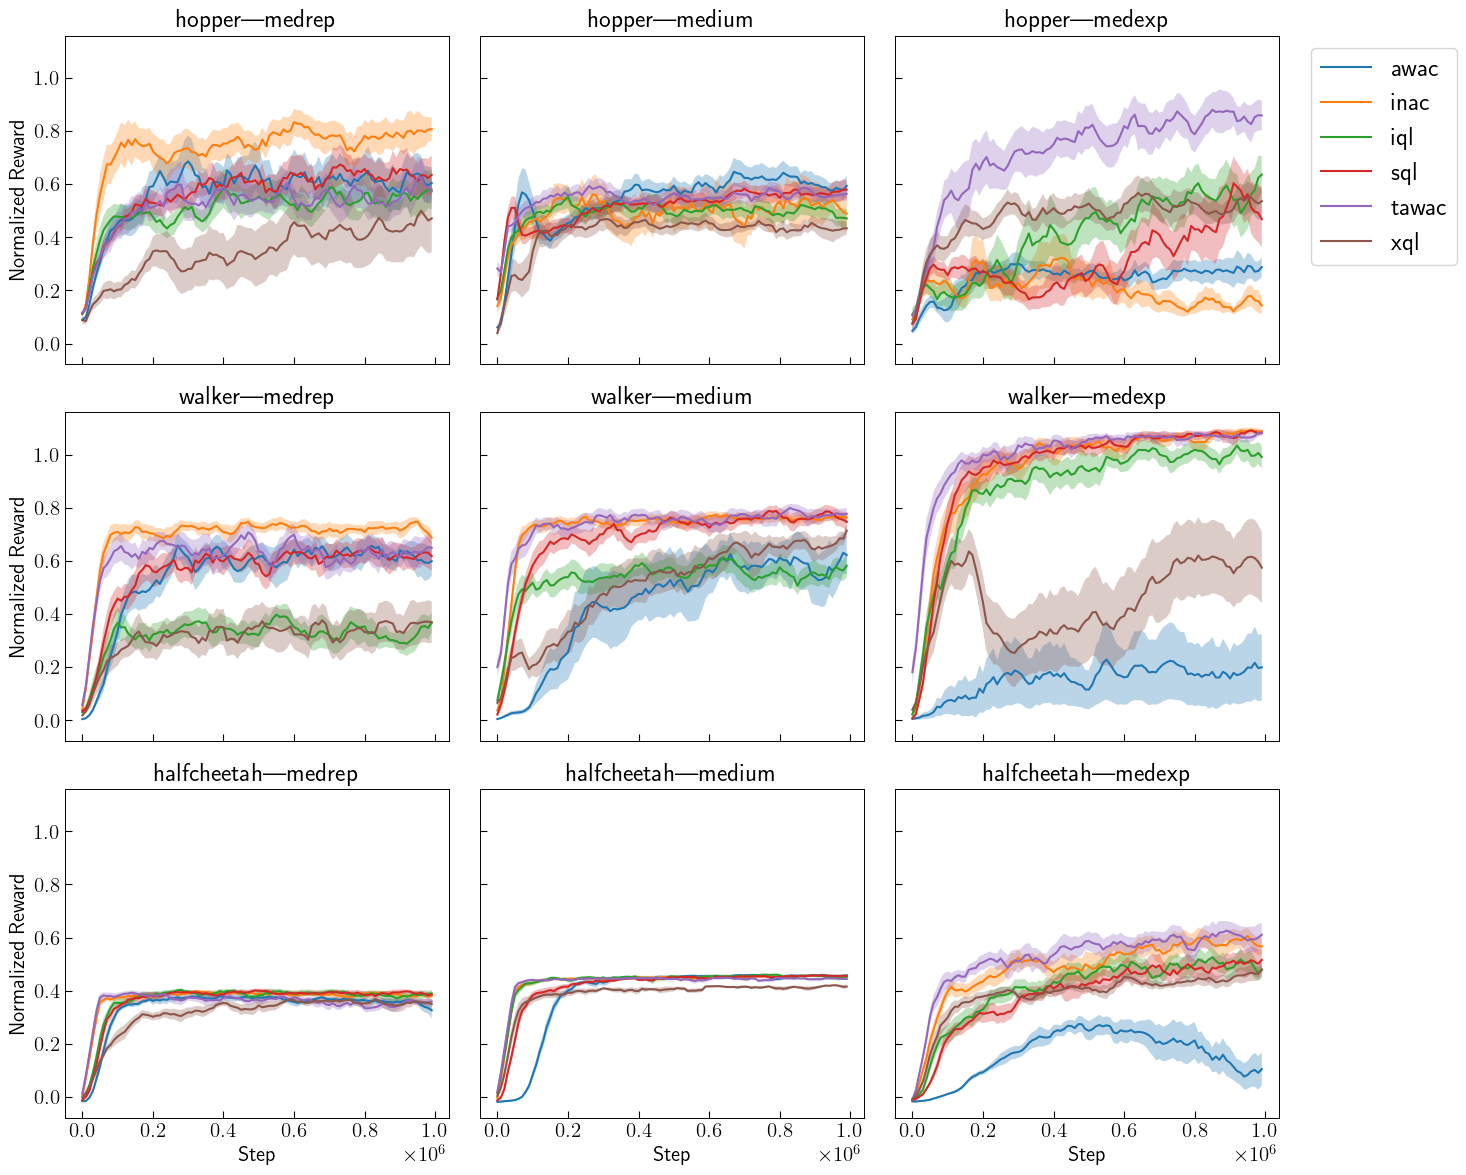

In [34]:
import sys
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

join_q = """
SELECT t.run
     , r.agent_name
     , r.agent_env
     , r.seed
     , t.step
     , t.reward_normalized
  FROM returns t
  JOIN runs    r ON t.run = r.run
"""
rets1 = db1.q(join_q)
rets2 = db2.q(join_q)
df = pd.concat([rets1, rets2], ignore_index=True)

envs = ['hopper', 'walker', 'halfcheetah']
diffs = ['medrep', 'medium', 'medexp']

agg = (
    df
    .groupby(['agent_env', 'agent_name', 'step'])
    .reward_normalized
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
agg['sem'] = agg['std'] / np.sqrt(agg['count'])

# ——— plot ———
fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(15, 12),
    sharex=True, sharey=True
)

smooth_n = 5  # smoothing window
for i, env in enumerate(envs):
    for j, diff in enumerate(diffs):
        ax = axes[i, j]
        env_name = f"{env}-{diff}"
        sub = agg[agg['agent_env'] == env_name]
        for agent in sub['agent_name'].unique():
            sub_a = sub[sub['agent_name'] == agent].sort_values('step')
            x = sub_a['step'].values
            y = moving_avg(sub_a['mean'].values, n=smooth_n)
            sem = moving_avg(sub_a['sem'].values, n=smooth_n)
            ax.plot(x, y, label=agent)
            ax.fill_between(x, y - sem, y + sem, alpha=0.3)
        ax.set_title(f"{env}—{diff}")
        if j == 0:
            ax.set_ylabel("Normalized Reward")
        if i == 2:
            ax.set_xlabel("Step")
        if i == 0 and j == 2:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [69]:
df_all['agent_env'].str.lower()

0         halfcheetah-medexp
1         halfcheetah-medexp
2         halfcheetah-medexp
3         halfcheetah-medexp
4         halfcheetah-medexp
                 ...        
146995              walker2d
146996              walker2d
146997              walker2d
146998              walker2d
146999              walker2d
Name: agent_env, Length: 147000, dtype: object

In [88]:
rename r.agent_env as r.env_name - r.env_dataset

['medrep', 'medium', 'medexp']

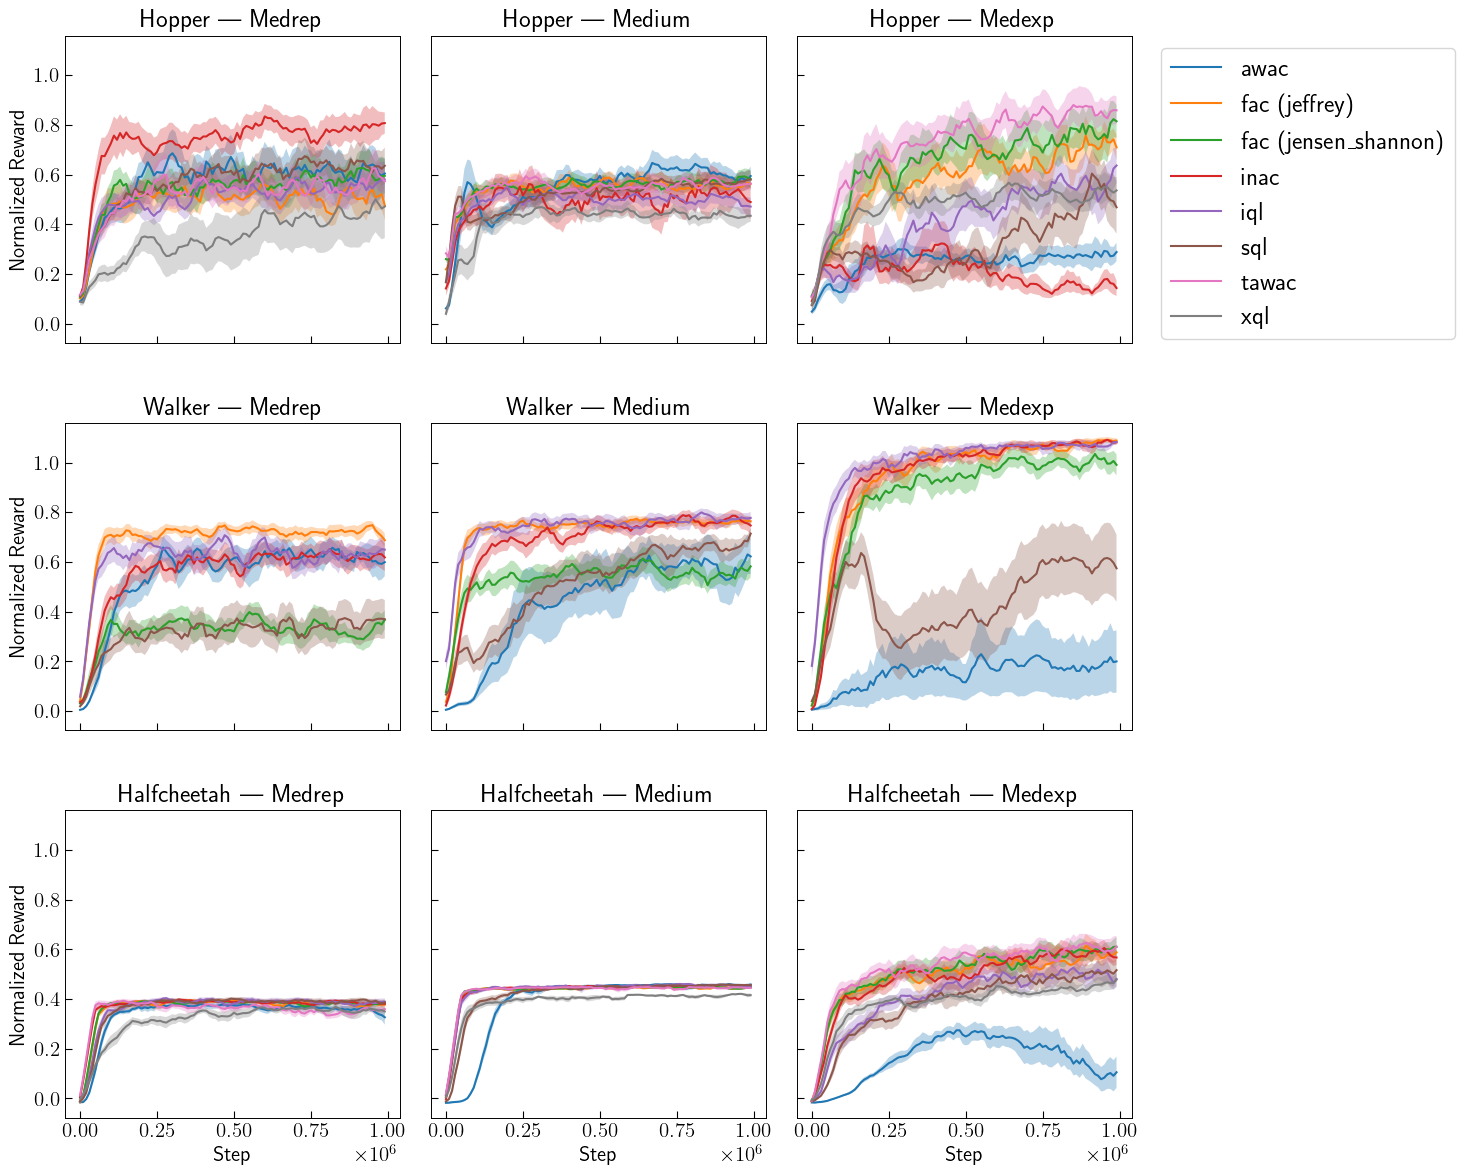

In [91]:

# ——— 2) Define two SQL queries ———
# (a) basic for the original DBs
join_q_basic = """
SELECT
    t.run,
    r.agent_name,
    r.agent_env,
    r.seed,
    t.step,
    t.reward_normalized
FROM returns t
JOIN runs r ON t.run = r.run
"""

# (b) fac for the FAC DBs, building agent_env from env_name + env_dataset
join_q_fac = """
SELECT
    t.run,
    r.agent_name,
    CONCAT(LOWER(r.env_name), '-', r.env_dataset) AS agent_env,
    r.seed,
    r.agent_fname,
    r.agent_num_terms,
    r.agent_alpha,
    r.agent_critic_optimizer_lr,
    r.agent_symmetric_coef,
    t.step,
    t.reward_normalized
FROM returns t
JOIN runs r ON t.run = r.run
"""

# ——— 3) Load & unify schemas ———
dfs = []

# original DBs: run basic query, then pad FAC-only cols with NaN
for db in (db1, db2):
    df = db.q(join_q_basic)
    for c in ('agent_fname',
              'agent_num_terms',
              'agent_alpha',
              'agent_critic_optimizer_lr',
              'agent_symmetric_coef'):
        df[c] = np.nan
    dfs.append(df)

# FAC DBs: run fac query (they already have those cols)
for db in (dbFH, dbFW):
    dfs.append(db.q(join_q_fac))

# combine everything
df_all = pd.concat(dfs, ignore_index=True)

# ——— 4) Define best‐hyperparameter filters for FAC Jensen–Shannon & Jeffrey ———
js_best = {
    ('jensen_shannon','halfcheetah','medrep'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jensen_shannon','halfcheetah','medium'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jensen_shannon','halfcheetah','medexp'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jensen_shannon','hopper',     'medrep'):  {'agent_num_terms':3.0,'agent_alpha':0.001,'agent_critic_optimizer_lr':0.001,'agent_symmetric_coef':1.0},
    ('jensen_shannon','hopper',     'medium'):  {'agent_num_terms':3.0,'agent_alpha':0.001,'agent_critic_optimizer_lr':0.001,'agent_symmetric_coef':1.0},
    ('jensen_shannon','hopper',     'medexp'):  {'agent_num_terms':3.0,'agent_alpha':0.01, 'agent_critic_optimizer_lr':0.001,'agent_symmetric_coef':1.0},
    ('jensen_shannon','walker',     'medrep'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jensen_shannon','walker',     'medium'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jensen_shannon','walker',     'medexp'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
}
jf_best = {
    ('jeffrey','halfcheetah','medrep'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jeffrey','halfcheetah','medium'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','halfcheetah','medexp'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','hopper',     'medrep'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jeffrey','hopper',     'medium'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','hopper',     'medexp'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','walker',     'medrep'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','walker',     'medium'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','walker',     'medexp'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
}

# build a DataFrame of only the best FAC runs
fac_rows = []
for (fname, env, diff), params in {**js_best, **jf_best}.items():
    mask = (
        (df_all['agent_name']=='fac') &
        (df_all['agent_fname']==fname) &
        (df_all['agent_env']==f"{env}-{diff}")
    )
    for col,val in params.items():
        mask &= (df_all[col] == val)
    fac_rows.append(df_all[mask])
fac_df = pd.concat(fac_rows, ignore_index=True)

# isolate the original (non-fac) runs
orig_df = df_all[df_all['agent_name'] != 'fac']

# combine them, and assign plotting labels
combined = pd.concat([orig_df, fac_df], ignore_index=True)
combined['plot_label'] = combined.apply(
    lambda r: f"{r.agent_name} ({r.agent_fname})" if r.agent_name=='fac' else r.agent_name,
    axis=1
)

# ——— 5) Aggregate mean & SEM over seeds ———
agg = (
    combined
    .groupby(['agent_env','plot_label','step'])
    .reward_normalized
    .agg(['mean','std','count'])
    .reset_index()
)
agg['sem'] = agg['std'] / np.sqrt(agg['count'])

# ——— 6) Plot the 3×3 grid with fac(JS/JF) lines ———
envs  = ['hopper','walker','halfcheetah']
diffs = ['medrep','medium','medexp']
fig, axes = plt.subplots(3,3,figsize=(15,12), sharex=True, sharey=True)
smooth_n = 5

for i, env in enumerate(envs):
    for j, diff in enumerate(diffs):
        ax = axes[i,j]
        sub = agg[agg['agent_env']==f"{env}-{diff}"]
        for label in sub['plot_label'].unique():
            s2 = sub[sub['plot_label']==label].sort_values('step')
            x = s2['step'].values
            y = moving_avg(s2['mean'].values, n=smooth_n)
            e = moving_avg(s2['sem'].values,  n=smooth_n)
            ax.plot(x, y, label=label)
            ax.fill_between(x, y-e, y+e, alpha=0.3)
        ax.set_title(f"{env.capitalize()} — {diff.capitalize()}")
        if j==0:   ax.set_ylabel("Normalized Reward")
        if i==2:   ax.set_xlabel("Step")
        if i==0 and j==2:
            ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.show()

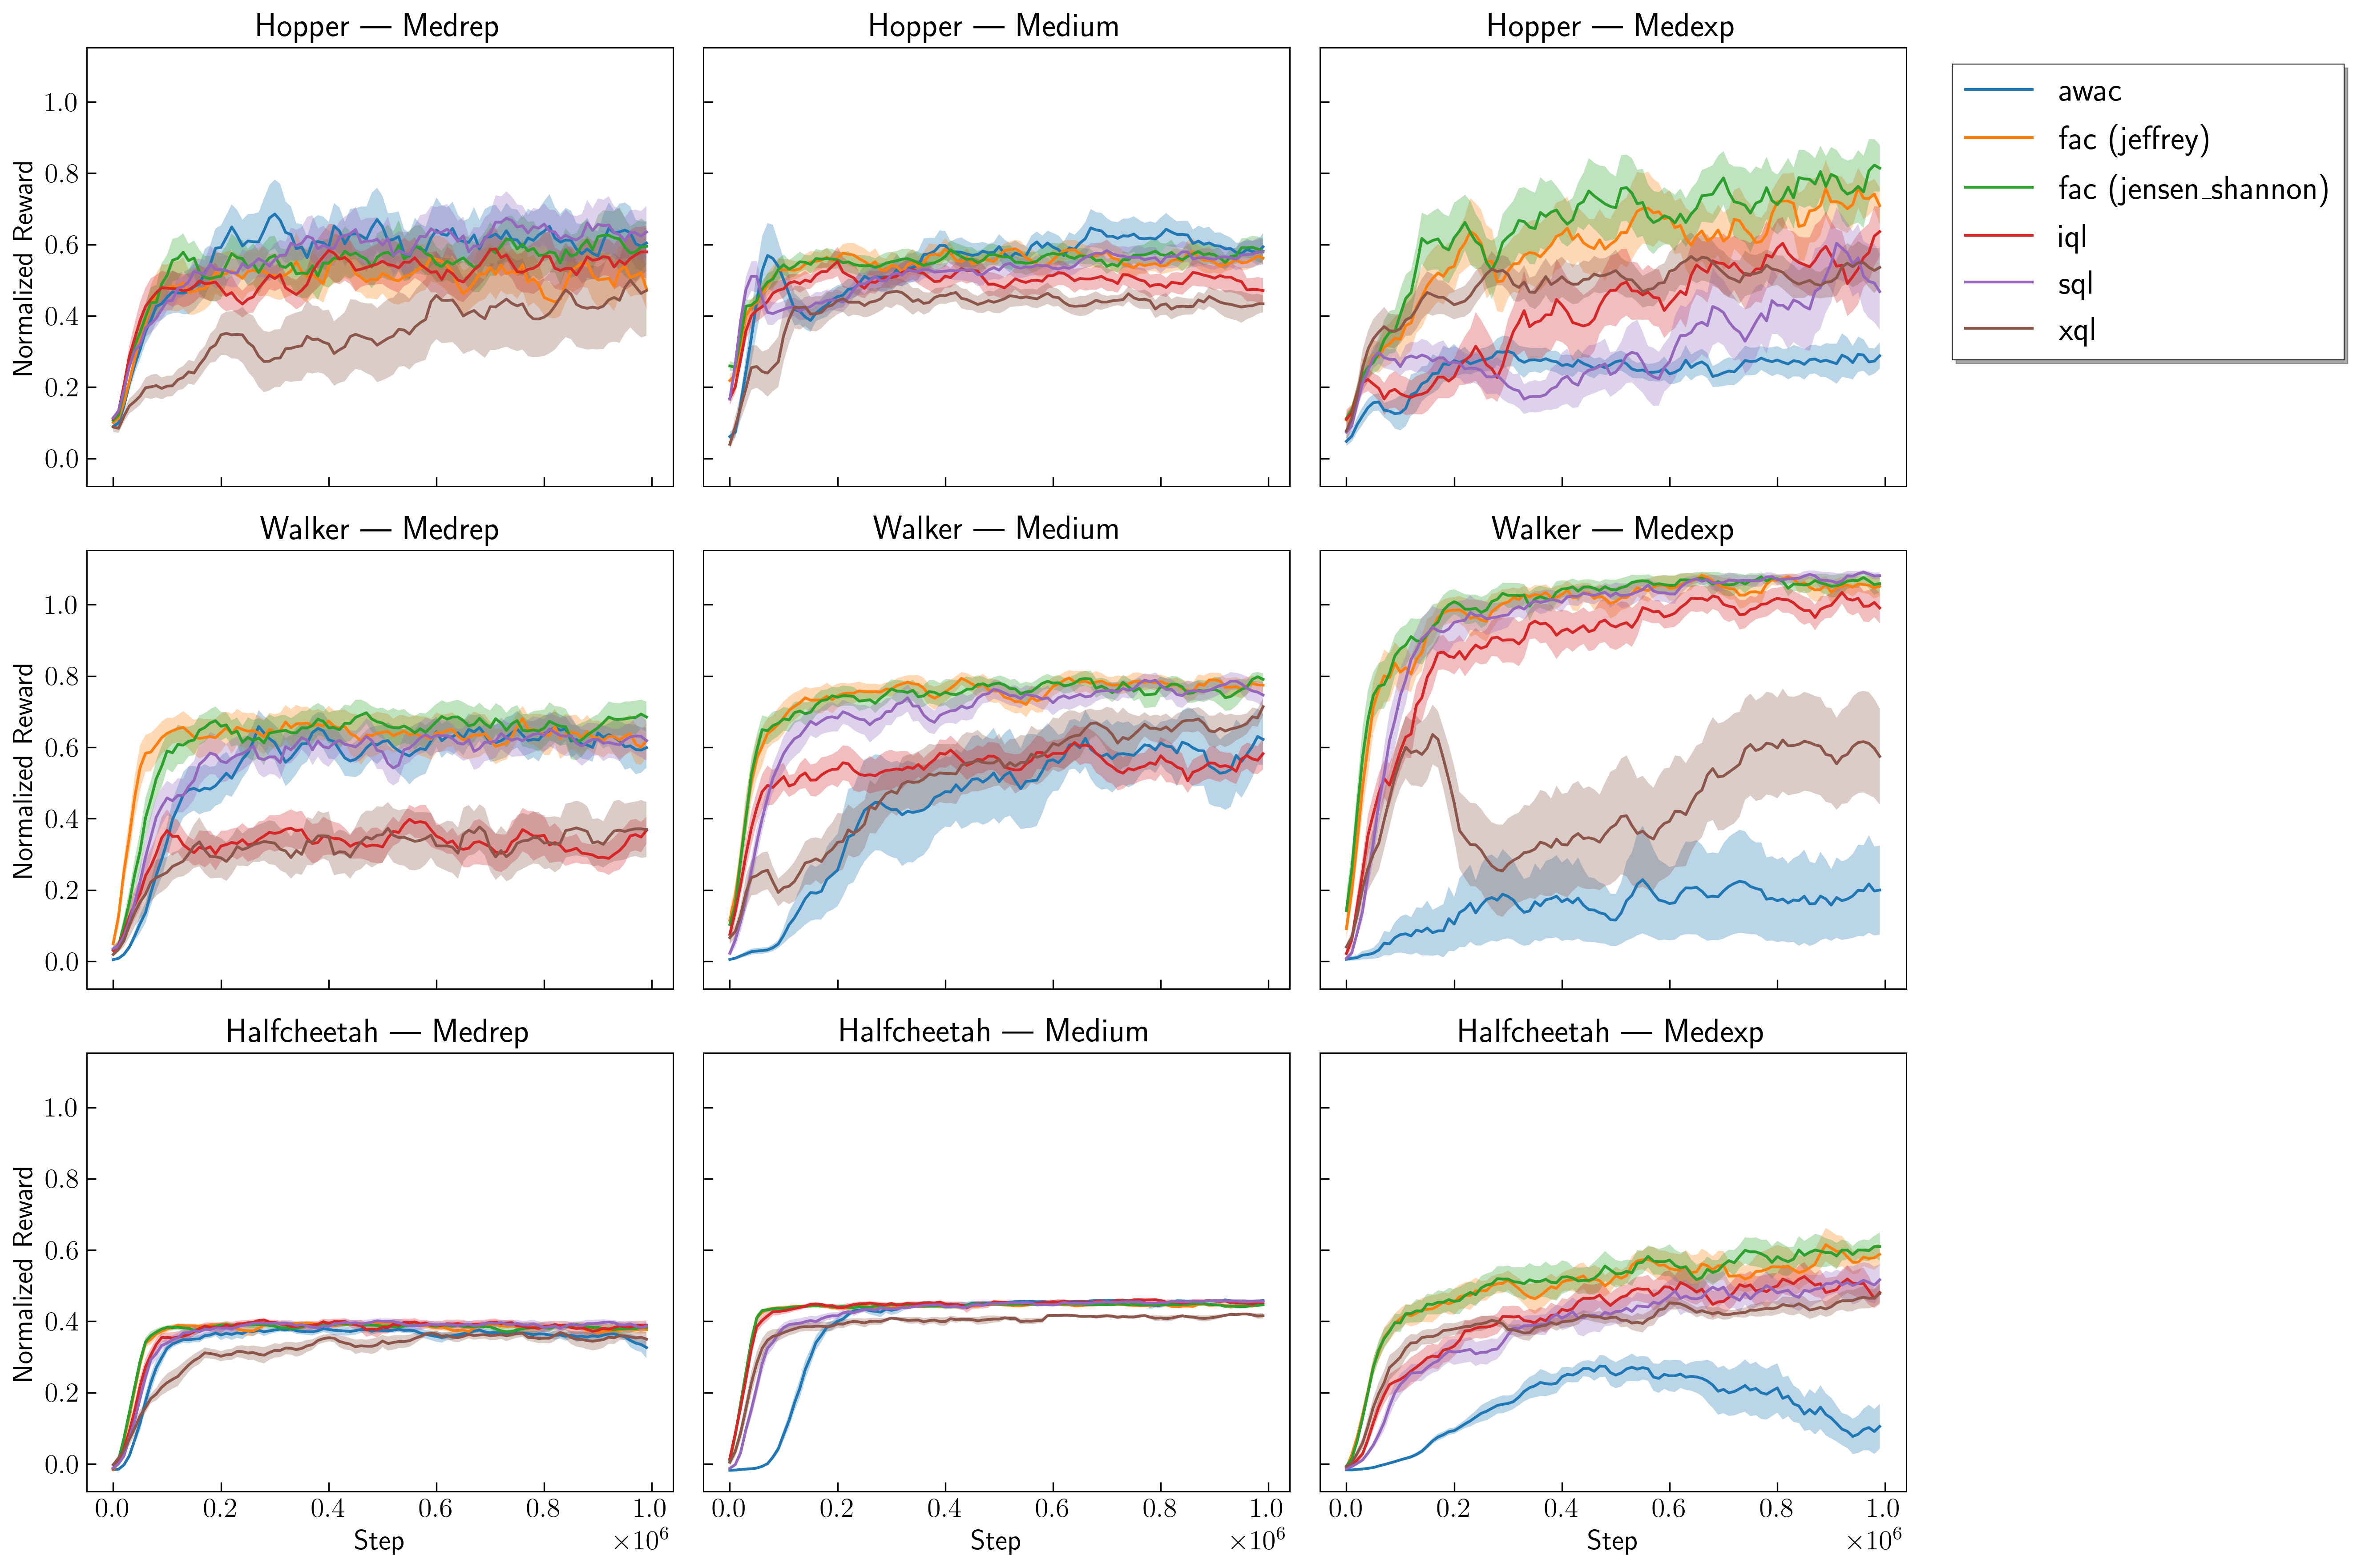

In [46]:

join_q_basic = """
SELECT
    t.run,
    r.agent_name,
    r.agent_env,
    r.seed,
    t.step,
    t.reward_normalized
FROM returns t
JOIN runs r ON t.run = r.run
"""

join_q_fac = """
SELECT
    t.run,
    r.agent_name,
    CONCAT(LOWER(r.env_name), '-', r.env_dataset) AS agent_env,
    r.seed,
    r.agent_fname,
    r.agent_num_terms,
    r.agent_alpha,
    r.agent_critic_optimizer_lr,
    r.agent_symmetric_coef,
    t.step,
    t.reward_normalized
FROM returns t
JOIN runs r ON t.run = r.run
"""

dfs = []

# run basic query, then pad FAC-only cols with NaN
for db in (db1, db2):
    df = db.q(join_q_basic)
    for c in ('agent_fname',
              'agent_num_terms',
              'agent_alpha',
              'agent_critic_optimizer_lr',
              'agent_symmetric_coef'):
        df[c] = np.nan
    dfs.append(df)

for db in (dbFH, dbFW):
    dfs.append(db.q(join_q_fac))

df_all = pd.concat(dfs, ignore_index=True)

# ——— 4) Define best‐hyperparameter filters for FAC Jensen–Shannon & Jeffrey ———
js_best = {
    ('jensen_shannon','halfcheetah','medrep'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jensen_shannon','halfcheetah','medium'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jensen_shannon','halfcheetah','medexp'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jensen_shannon','hopper',     'medrep'):  {'agent_num_terms':3.0,'agent_alpha':0.001,'agent_critic_optimizer_lr':0.001,'agent_symmetric_coef':1.0},
    ('jensen_shannon','hopper',     'medium'):  {'agent_num_terms':3.0,'agent_alpha':0.001,'agent_critic_optimizer_lr':0.001,'agent_symmetric_coef':1.0},
    ('jensen_shannon','hopper',     'medexp'):  {'agent_num_terms':3.0,'agent_alpha':0.01, 'agent_critic_optimizer_lr':0.001,'agent_symmetric_coef':1.0},
    ('jensen_shannon','walker',     'medrep'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jensen_shannon','walker',     'medium'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jensen_shannon','walker',     'medexp'):  {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
}
jf_best = {
    ('jeffrey','halfcheetah','medrep'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jeffrey','halfcheetah','medium'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','halfcheetah','medexp'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','hopper',     'medrep'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.0003,'agent_symmetric_coef':1.0},
    ('jeffrey','hopper',     'medium'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','hopper',     'medexp'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','walker',     'medrep'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','walker',     'medium'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
    ('jeffrey','walker',     'medexp'):    {'agent_num_terms':3.0,'agent_alpha':0.01,'agent_critic_optimizer_lr':0.001, 'agent_symmetric_coef':1.0},
}

# build a DataFrame of only the best FAC runs
fac_rows = []
for (fname, env, diff), params in {**js_best, **jf_best}.items():
    mask = (
        (df_all['agent_name']=='fac') &
        (df_all['agent_fname']==fname) &
        (df_all['agent_env']==f"{env}-{diff}")
    )
    for col,val in params.items():
        mask &= (df_all[col] == val)
    fac_rows.append(df_all[mask])
fac_df = pd.concat(fac_rows, ignore_index=True)

orig_df = df_all[df_all['agent_name'] != 'fac']
orig_df = orig_df[df_all['agent_name'] != 'inac']
orig_df = orig_df[df_all['agent_name'] != 'tawac']

combined = pd.concat([orig_df, fac_df], ignore_index=True)
combined['plot_label'] = combined.apply(
    lambda r: f"{r.agent_name} ({r.agent_fname})" if r.agent_name=='fac' else r.agent_name,
    axis=1
)

agg = (
    combined
    .groupby(['agent_env','plot_label','step'])
    .reward_normalized
    .agg(['mean','std','count'])
    .reset_index()
)
agg['sem'] = agg['std'] / np.sqrt(agg['count'])

# ——— 6) Plot the 3×3 grid with fac(JS/JF) lines ———
envs  = ['hopper','walker','halfcheetah']
diffs = ['medrep','medium','medexp']



plot_config = {
    'figsize': (18, 12),
    'dpi': 300,
    'marker_size': 12,
    'scatter_alpha': 1,
    'box_width': 40,
    'group_width': 600,       # Total width for each actor group
    'inter_group_gap': 50,   # Space between actor groups
    'intra_group_pad': 10,    # Padding within actor groups
    'background_padding': 50, # Padding for shaded regions
    'jitter_ratio': 0.3,       # Jitter width relative to cluster space
    'boxplot_alpha': 0.1

}

#fig, axes = plt.subplots(4, 2, figsize=plot_config['figsize'], dpi=plot_config['dpi'])

fig, axes = plt.subplots(3,3,figsize=plot_config['figsize'], dpi=plot_config['dpi'], sharex=True, sharey=True)
smooth_n = 5

for i, env in enumerate(envs):
    for j, diff in enumerate(diffs):
        ax = axes[i,j]
        sub = agg[agg['agent_env']==f"{env}-{diff}"]
        for label in sub['plot_label'].unique():
            s2 = sub[sub['plot_label']==label].sort_values('step')
            x = s2['step'].values
            y = moving_avg(s2['mean'].values, n=smooth_n)
            e = moving_avg(s2['sem'].values,  n=smooth_n)
            ax.plot(x, y, label=label)
            ax.fill_between(x, y-e, y+e, alpha=0.3)
        ax.set_title(f"{env.capitalize()} — {diff.capitalize()}")
        if j==0:   ax.set_ylabel("Normalized Reward")
        if i==2:   ax.set_xlabel("Step")
        if i==0 and j==2:
            legend = ax.legend(bbox_to_anchor=(1.05,1), loc='upper left', fancybox=True, shadow=True,)
            legend.get_frame().set_boxstyle('Round', pad=0, rounding_size=0)
            
            frame = legend.get_frame()
            
            frame.set_linewidth(0.5)
            frame.set_edgecolor('black')



plt.tight_layout()
plt.show()

In [27]:
# SQL to replace “walker2d” with “walker” in agent_env
update_sql = """
UPDATE runs
   SET env_name = REPLACE(env_name, 'Walker2d', 'walker')
 WHERE env_name LIKE '%Walker2d%';
"""

cursor = dbFW.conn.cursor()
cursor.execute(update_sql)
dbFW.conn.commit()
print(f"{cursor.rowcount} rows updated in fac_walker2d.runs")


360 rows updated in fac_walker2d.runs
